In [1]:
import warnings
warnings.filterwarnings('ignore')
import json
import pandas as pd
import re
import emoji
import nltk
import string
from spellchecker import SpellChecker
import json
from collections import Counter
from textstat import textstat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.feature_selection import SelectFromModel
from transformers import T5ForConditionalGeneration, T5Tokenizer
import torch
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score
from rouge import Rouge
import os
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from datasets import concatenate_datasets
import evaluate
from transformers import DataCollatorForSeq2Seq
from huggingface_hub import HfFolder
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
from transformers import pipeline
from random import randrange
from nltk.tokenize import sent_tokenize


# Download necessary NLTK data
nltk.download('punkt')
nltk.download('punkt_tab')
# nltk.download('all')

/tmp/rohan/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-29 19:51:59.223634: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-29 19:51:59.235141: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745956319.248358 3087446 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745956319.252304 3087446 cuda_blas.cc:1407] Unable to register 

True

In [2]:
root_path = 'corpus/'
path='corpus/data-processing/'

In [3]:
# Load the dataset
with open(root_path + 'train.json', 'r', encoding='utf-8') as f:
    train_data = json.load(f)
with open(root_path + 'test.json', 'r', encoding='utf-8') as f:
    test_data = json.load(f)
with open(root_path + 'val.json', 'r', encoding='utf-8') as f:
    eval_data = json.load(f)

# Convert to DataFrames
train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)
eval_df = pd.DataFrame(eval_data)

# Combine all three into one
full_df = pd.concat([train_df, eval_df], ignore_index=True)

In [4]:
with open(root_path + 'cleaned_train_conversations.json', 'r', encoding='utf-8') as f:
    processed_dialogues = json.load(f)

In [5]:
model_id="google/flan-t5-base"

# Load tokenizer of FLAN-t5-base
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [6]:
from datasets import Dataset

# Convert the list of dicts into a Dataset
processed_dialogues_dataset = Dataset.from_list(processed_dialogues)


# The maximum total input sequence length after tokenization.
tokenized_inputs = processed_dialogues_dataset.map(lambda x: tokenizer(x["dialogue"], truncation=True), batched=True, remove_columns=["dialogue", "summary"])
max_source_length = max([len(x) for x in tokenized_inputs["input_ids"]])
print(f"Max source length: {max_source_length}")

# The maximum total sequence length for target text after tokenization.
tokenized_targets = processed_dialogues_dataset.map(lambda x: tokenizer(x["summary"], truncation=True), batched=True, remove_columns=["dialogue", "summary"])
max_target_length = max([len(x) for x in tokenized_targets["input_ids"]])
print(f"Max target length: {max_target_length}")

Map: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15549/15549 [00:01<00:00, 12841.74 examples/s]


Max source length: 512


Map: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15549/15549 [00:00<00:00, 35806.53 examples/s]


Max target length: 94


In [7]:
def preprocess_function(sample,padding="max_length"):
    # add prefix to the input for t5
    inputs = ["summarize: " + item for item in sample["dialogue"]]

    # tokenize inputs
    model_inputs = tokenizer(inputs, max_length=max_source_length, padding=padding, truncation=True)

    # Tokenize targets with the `text_target` keyword argument
    labels = tokenizer(text_target=sample["summary"], max_length=max_target_length, padding=padding, truncation=True)

    if padding == "max_length":
        labels["input_ids"] = [
            [(l if l != tokenizer.pad_token_id else -100) for l in label] for label in labels["input_ids"]
        ]

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_dataset = processed_dialogues_dataset.map(preprocess_function, batched=True, remove_columns=["dialogue", "summary", "id"])
print(f"Keys of tokenized dataset: {list(tokenized_dataset.features)}")

Map: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15549/15549 [00:06<00:00, 2290.06 examples/s]

Keys of tokenized dataset: ['input_ids', 'attention_mask', 'labels']


In [8]:
from transformers import AutoModelForSeq2SeqLM

# load model from the hub
model = AutoModelForSeq2SeqLM.from_pretrained(model_id)

In [10]:
# Metric
metric = evaluate.load("rouge")
# from datasets import load_metric
# metric = load_metric("rouge")


# helper function to postprocess text
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]

    # rougeLSum expects newline after each sentence
    preds = ["\n".join(sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(sent_tokenize(label)) for label in labels]

    return preds, labels

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    new_result = {}
    for k, v in result.items():
        if isinstance(v, dict):
            # dict like {'precision':..., 'recall':..., 'fmeasure':...}
            f1 = v.get("fmeasure", 0.0)
            new_result[k] = round(float(f1) * 100, 4)
        elif isinstance(v, (tuple, list)):
            try:
#                 f1 = v[2]
#                 new_result[k] = round(float(f1) * 100, 4)
                new_result[k] = round(v.mid.fmeasure * 100, 4)
            except (IndexError, TypeError):
                new_result[k] = 0.0
        elif isinstance(v, (float, int)):
            new_result[k] = round(float(v) * 100, 4)
        else:
            # fallback: unknown structure
            new_result[k] = 0.0

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    new_result["gen_len"] = np.mean(prediction_lens)

    return new_result



In [11]:
from transformers import DataCollatorForSeq2Seq

class SafeDataCollator(DataCollatorForSeq2Seq):
    def __call__(self, features):
        batch = super().__call__(features)

        def find_bad_tokens(name, tensor):
            # Find token IDs that are invalid
            bad_positions = (tensor < 0) | (tensor >= self.tokenizer.vocab_size)
            if bad_positions.any():
                bad_ids = tensor[bad_positions]

        # Check input_ids
        if "input_ids" in batch:
            find_bad_tokens("input_ids", batch["input_ids"])
            batch["input_ids"] = batch["input_ids"].clamp_(0, self.tokenizer.vocab_size - 1)

        # Check labels (target ids)
        if "labels" in batch:
            find_bad_tokens("labels", batch["labels"])
            batch["labels"] = batch["labels"].clamp_(0, self.tokenizer.vocab_size - 1)

        return batch


In [12]:
# we want to ignore tokenizer pad token in the loss
label_pad_token_id = -100
# Data collator
data_collator = SafeDataCollator(
    tokenizer,
    model=model,
    label_pad_token_id=label_pad_token_id,
    pad_to_multiple_of=8
)


In [13]:
# Split into 80% train and 20% validation
split_dataset = tokenized_dataset.train_test_split(test_size=0.2, seed=42)

# Get train and validation sets
train_dataset = split_dataset['train']
test_dataset = split_dataset['test']

In [14]:
# Define training args
training_args = Seq2SeqTrainingArguments(
    output_dir=path,
    # per_device_train_batch_size=8,
    # per_device_eval_batch_size=8,
    predict_with_generate=True,
    learning_rate=5e-5,
    num_train_epochs=10,
    logging_dir=f"{path}/logs",
    logging_strategy="steps",
    logging_steps=500,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    report_to="none",
)

# Create Trainer instance
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

In [15]:
# Start training
trainer.train()

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
/tmp/rohan/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,1.893500,0.413087,47.485900,24.441600,40.308000,44.121600,17.605788
2,0.459000,0.408064,47.734100,24.699700,40.537000,44.298400,17.806431
3,0.438700,0.404936,47.704100,24.653700,40.633900,44.280800,17.625080
4,0.419800,0.404301,47.783800,24.657200,40.674100,44.386400,17.794534
5,0.409700,0.405399,47.961200,24.843200,40.776500,44.473700,17.802251
6,0.395300,0.404949,47.713500,24.777300,40.663000,44.291300,17.944695
7,0.387500,0.405766,48.040500,24.842900,40.825200,44.506000,17.762701
8,0.377000,0.405827,48.111300,24.875000,40.823600,44.543200,17.955627
9,0.373400,0.406526,47.964500,24.839600,40.741100,44.428400,17.853055
10,0.373900,0.406806,47.945000,24.824700,40.729600,44.395700,17.841479


/tmp/rohan/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/tmp/rohan/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/tmp/rohan/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/tmp/rohan/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/tmp/rohan/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked t

TrainOutput(global_step=7780, training_loss=0.5016488416029432, metrics={'train_runtime': 4583.2906, 'train_samples_per_second': 27.14, 'train_steps_per_second': 1.697, 'total_flos': 8.517696707100672e+16, 'train_loss': 0.5016488416029432, 'epoch': 10.0})

In [16]:
trainer.evaluate()

/tmp/rohan/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'eval_loss': 0.40430063009262085,
 'eval_rouge1': 47.7838,
 'eval_rouge2': 24.6572,
 'eval_rougeL': 40.6741,
 'eval_rougeLsum': 44.3864,
 'eval_gen_len': 17.794533762057878,
 'eval_runtime': 113.5279,
 'eval_samples_per_second': 27.394,
 'eval_steps_per_second': 1.718,
 'epoch': 10.0}

In [18]:

tokenizer.save_pretrained(path+'/flan-t5-base')
trainer.create_model_card()

# Save the model
# trainer.save_pretrained(path+"/saved_model")
trainer.save_model(path+"/flan-t5-base")


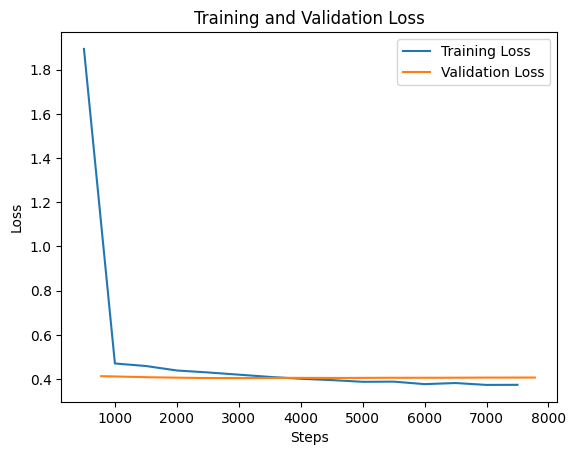

In [20]:
import json
import matplotlib.pyplot as plt

# Load the trainer_state.json
with open(path+'/checkpoint-7780/trainer_state.json', 'r') as f:
    trainer_state = json.load(f)

# Extract logs
logs = trainer_state['log_history']

# Separate the values
steps = []
losses = []
eval_losses = []

for log in logs:
    if 'loss' in log:
        steps.append(log['step'])
        losses.append(log['loss'])
    if 'eval_loss' in log:
        eval_losses.append((log['step'], log['eval_loss']))

# Plot training loss
plt.plot(steps, losses, label='Training Loss')
if eval_losses:
    eval_steps, eval_vals = zip(*eval_losses)
    plt.plot(eval_steps, eval_vals, label='Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


In [24]:

# load model and tokenizer from huggingface hub with pipeline
summarizer = pipeline("summarization", model=path+'/flan-t5-base')

# select a random test sample
sample = test_df.iloc[randrange(len(test_df))]
print(f"dialogue: \n{sample['dialogue']}\n---------------")
print(f"Human Summary: \n{sample['summary']}")
# summarize dialogue
res = summarizer(sample["dialogue"])

print(f"flan-t5-base summary:\n{res[0]['summary_text']}")

Device set to use cuda:0


dialogue: 
Charles: What are you up to this weekend?
Camilla: Not much. Just some work and errands on Saturday, show Saturday night. Day of nothingness on Sundy.
Charles: Sounds good. We are going to visit the German markets this weekend. Birmingham and Manchester both. Sausage overload!
Camilla: Ooh, that sounds really good!
Charles: Allegedly there are Christmas things going on but I just go for the sausage and beer!
Camilla: What a shocker.
Charles: I know!
Camilla: I'll have to try to get there this year. I've not been for ages.
Charles: Oh, yeah, they are good. Try the mulled wine too. That's nice.
Camilla: Never had it. Is it served hot?
Charles: Yes, exactly. And lots of spices. Usually a red but sometimes they offer a mulled white.
Camilla: I'm good with red.
Charles: Inspired us to make our own at Christmas last year, but nobody else drank it.
Camilla: Bummer!
Charles: More for me! But oh the hangover.
Camilla: LOL!
Charles: Anyway, that's the plan. Hope you have fun.
Camilla: